### Tactron 2 paper implementation


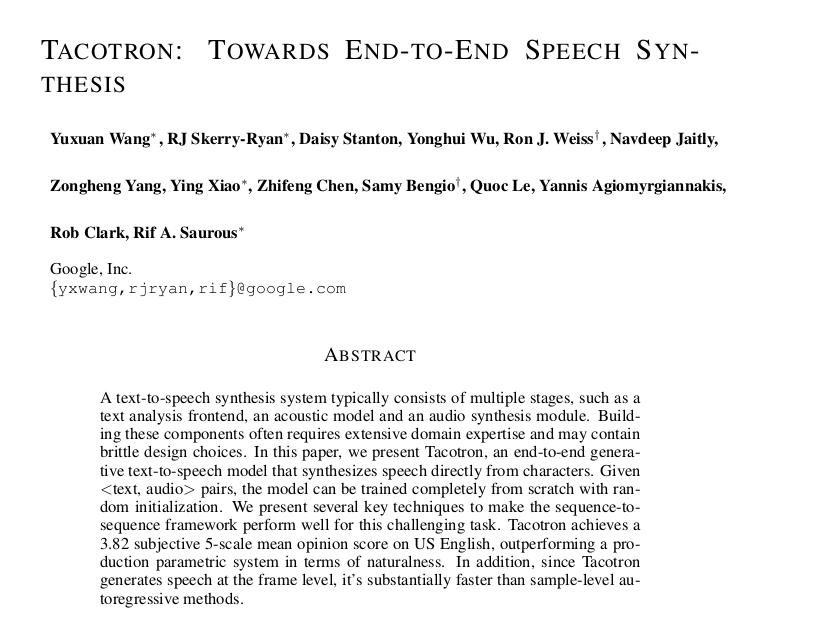

In [1]:
from IPython.display import Image
Image(filename='../images/tactron.png')


## Prelims

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

In [3]:
class Tacotron(nn.Module):
    def __init__(self,
                 num_chars,
                 num_speakers,
                 r=5,
                 postnet_output_dim=1025,
                 decoder_output_dim=80,
                 memory_size=5,
                 attn_type='original',
                 attn_win=False,
                 gst=False,
                 attn_norm="sigmoid",
                 prenet_type="original",
                 prenet_dropout=True,
                 forward_attn=False,
                 trans_agent=False,
                 forward_attn_mask=False,
                 location_attn=True,
                 attn_K=5,
                 separate_stopnet=True,
                 bidirectional_decoder=False):
        super(Tacotron, self).__init__()
        self.r = r
        self.decoder_output_dim = decoder_output_dim
        self.postnet_output_dim = postnet_output_dim
        self.gst = gst
        self.num_speakers = num_speakers
        self.bidirectional_decoder = bidirectional_decoder
        decoder_dim = 512 if num_speakers > 1 else 256
        encoder_dim = 512 if num_speakers > 1 else 256
        proj_speaker_dim = 80 if num_speakers > 1 else 0
        # embedding layer
        self.embedding = nn.Embedding(num_chars, 256)
        self.embedding.weight.data.normal_(0, 0.3)
        # boilerplate model
        self.encoder = Encoder(encoder_dim)
        self.decoder = Decoder(decoder_dim, decoder_output_dim, r, memory_size, attn_type, attn_win,
                               attn_norm, prenet_type, prenet_dropout,
                               forward_attn, trans_agent, forward_attn_mask,
                               location_attn, attn_K, separate_stopnet,
                               proj_speaker_dim)
        if self.bidirectional_decoder:
            self.decoder_backward = copy.deepcopy(self.decoder)
        self.postnet = PostCBHG(decoder_output_dim)
        self.last_linear = nn.Linear(self.postnet.cbhg.gru_features * 2,
                                     postnet_output_dim)
        # speaker embedding layers
        if num_speakers > 1:
            self.speaker_embedding = nn.Embedding(num_speakers, 256)
            self.speaker_embedding.weight.data.normal_(0, 0.3)
            self.speaker_project_mel = nn.Sequential(
                nn.Linear(256, proj_speaker_dim), nn.Tanh())
            self.speaker_embeddings = None
            self.speaker_embeddings_projected = None
        # global style token layers
        if self.gst:
            gst_embedding_dim = 256
            self.gst_layer = GST(num_mel=80,
                                 num_heads=4,
                                 num_style_tokens=10,
                                 embedding_dim=gst_embedding_dim)

    def _init_states(self):
        self.speaker_embeddings = None
        self.speaker_embeddings_projected = None

    def compute_speaker_embedding(self, speaker_ids):
        if hasattr(self, "speaker_embedding") and speaker_ids is None:
            raise RuntimeError(
                " [!] Model has speaker embedding layer but speaker_id is not provided"
            )
        if hasattr(self, "speaker_embedding") and speaker_ids is not None:
            self.speaker_embeddings = self._compute_speaker_embedding(
                speaker_ids)
            self.speaker_embeddings_projected = self.speaker_project_mel(
                self.speaker_embeddings).squeeze(1)

    def compute_gst(self, inputs, mel_specs):
        gst_outputs = self.gst_layer(mel_specs)
        inputs = self._add_speaker_embedding(inputs, gst_outputs)
        return inputs

    def forward(self, characters, text_lengths, mel_specs, speaker_ids=None):
        """
        Shapes:
            - characters: B x T_in
            - text_lengths: B
            - mel_specs: B x T_out x D
            - speaker_ids: B x 1
        """
        self._init_states()
        mask = sequence_mask(text_lengths).to(characters.device)
        # B x T_in x embed_dim
        inputs = self.embedding(characters)
        # B x speaker_embed_dim
        self.compute_speaker_embedding(speaker_ids)
        if self.num_speakers > 1:
            # B x T_in x embed_dim + speaker_embed_dim
            inputs = self._concat_speaker_embedding(inputs,
                                                    self.speaker_embeddings)
        # B x T_in x encoder_dim
        encoder_outputs = self.encoder(inputs)
        if self.gst:
            # B x gst_dim
            encoder_outputs = self.compute_gst(encoder_outputs, mel_specs)
        if self.num_speakers > 1:
            encoder_outputs = self._concat_speaker_embedding(
                encoder_outputs, self.speaker_embeddings)
        # decoder_outputs: B x decoder_dim x T_out
        # alignments: B x T_in x encoder_dim
        # stop_tokens: B x T_in
        decoder_outputs, alignments, stop_tokens = self.decoder(
            encoder_outputs, mel_specs, mask,
            self.speaker_embeddings_projected)
        # B x T_out x decoder_dim
        postnet_outputs = self.postnet(decoder_outputs)
        # B x T_out x posnet_dim
        postnet_outputs = self.last_linear(postnet_outputs)
        # B x T_out x decoder_dim
        decoder_outputs = decoder_outputs.transpose(1, 2).contiguous()
        if self.bidirectional_decoder:
            decoder_outputs_backward, alignments_backward = self._backward_inference(mel_specs, encoder_outputs, mask)
            return decoder_outputs, postnet_outputs, alignments, stop_tokens, decoder_outputs_backward, alignments_backward
        return decoder_outputs, postnet_outputs, alignments, stop_tokens

    def inference(self, characters, speaker_ids=None, style_mel=None):
        inputs = self.embedding(characters)
        self._init_states()
        self.compute_speaker_embedding(speaker_ids)
        if self.num_speakers > 1:
            inputs = self._concat_speaker_embedding(inputs,
                                                    self.speaker_embeddings)
        encoder_outputs = self.encoder(inputs)
        if self.gst and style_mel is not None:
            encoder_outputs = self.compute_gst(encoder_outputs, style_mel)
        if self.num_speakers > 1:
            encoder_outputs = self._concat_speaker_embedding(
                encoder_outputs, self.speaker_embeddings)
        decoder_outputs, alignments, stop_tokens = self.decoder.inference(
            encoder_outputs, self.speaker_embeddings_projected)
        postnet_outputs = self.postnet(decoder_outputs)
        postnet_outputs = self.last_linear(postnet_outputs)
        decoder_outputs = decoder_outputs.transpose(1, 2)
        return decoder_outputs, postnet_outputs, alignments, stop_tokens

    def _backward_inference(self, mel_specs, encoder_outputs, mask):
        decoder_outputs_b, alignments_b, _ = self.decoder_backward(
            encoder_outputs, torch.flip(mel_specs, dims=(1,)), mask,
            self.speaker_embeddings_projected)
        decoder_outputs_b = decoder_outputs_b.transpose(1, 2).contiguous()
        return decoder_outputs_b, alignments_b

    def _compute_speaker_embedding(self, speaker_ids):
        speaker_embeddings = self.speaker_embedding(speaker_ids)
        return speaker_embeddings.unsqueeze_(1)

    @staticmethod
    def _add_speaker_embedding(outputs, speaker_embeddings):
        speaker_embeddings_ = speaker_embeddings.expand(
            outputs.size(0), outputs.size(1), -1)
        outputs = outputs + speaker_embeddings_
        return outputs

    @staticmethod
    def _concat_speaker_embedding(outputs, speaker_embeddings):
        speaker_embeddings_ = speaker_embeddings.expand(
            outputs.size(0), outputs.size(1), -1)
        outputs = torch.cat([outputs, speaker_embeddings_], dim=-1)
        return outputs


## Module Architecture


#### CBHG Module


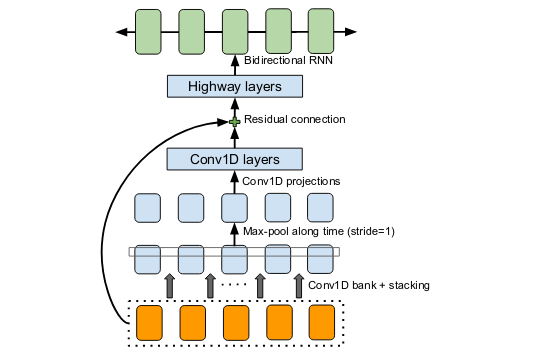

**From [1]**
We  first  describe  a  building  block  dubbed  CBHG,  illustrated  in  Figure  2.   CBHG  consists  of  abank of 1-D convolutional filters,  followed by highway networks (Srivastava et al., 2015) and abidirectional gated recurrent unit (GRU) (Chung et al., 2014) recurrent neural net (RNN). CBHGis a powerful module for extracting representations from sequences.   The input sequence is firstconvolved withKsets of 1-D convolutional filters, where thek-th set containsCkfilters of widthk(i.e.k= 1,2, . . . , K).  These filters explicitly model local and contextual information (akin tomodeling unigrams, bigrams, up toK-grams).  The convolution outputs are stacked together andfurther  max  pooled  along  time  to  increase  local  invariances.   Note  that  we  use  a  stride  of  1  topreserve the original time resolution.  We further pass the processed sequence to a few fixed-width1-D convolutions, whose outputs are added with the original input sequence via residual connections(He et al., 2016). Batch normalization (Ioffe & Szegedy, 2015) is used for all convolutional layers.The convolution outputs are fed into a multi-layer highway network to extract high-level features.Finally, we stack a bidirectional GRU RNN on top to extract sequential features from both forwardand  backward  context.   CBHG  is  inspired  from  work  in  machine  translation  (Lee  et  al.,  2016),where the  main differences from  Lee et al.  (2016) include  using non-causal convolutions,  batchnormalization, residual connections, and stride=1 max pooling.  We found that these modificationsimproved generalization.


In [4]:
class CBHG(nn.Module):
    def __init__(self, in_f, K=16, conv_blank_features=128, conv_projections=[128, 128], highway_features=128,
                 gru_features=128, num_highways=4):
        super(CBHG, self).__init__()
        self.in_f = in_f
        self.conv_b_f = conv_b_f
        self.hf = hf
        self.gru_f = gru_f
        self.relu = nn.ReLU()
        
        self.conv1d_banks = nn.ModuleList([
            BatchNormConv1d(in_f, conv_blank_features, kernel_size=k, stride=1, padding=[(k - 1) // 2, k // 2], activation=self.relu) for k in range(1, K+1)
        ])
        
        out_f = [K * conv_bank_features] + conv_projections[:-1]
        activations = [self.relu] * (len(conv_projections) - 1)
        activations += [None]
        
        layer_set = []
        for (in_s, out_s, ac) in zip(out_f, conv_projections[:-1], activations):
            layer = BatchNormConv1d(in_size,
                                    out_size,
                                    kernel_size=3,
                                    stride=1,
                                    padding=[1, 1],
                                    activation=ac)
            layer_set.append(layer)
            
        self.conv1d_projections = nn.ModuleList(layer_set)
        # setup Highway layers
        if self.highway_features != conv_projections[-1]:
            self.pre_highway = nn.Linear(conv_projections[-1],
                                         highway_features,
                                         bias=False)
        self.highways = nn.ModuleList([
            Highway(highway_features, highway_features) for _ in range(num_highways)
        ])
        self.gru = nn.GRU(gru_features, gru_features, 1, 
                         batch_first=True, bidirectional=True)
        
    def forward(self, inputs):
        x = inputs
        outs = []
        for conv1d in conv1d_banks:
            out = conv1d(x)
            outs.append(out)
        x = torch.cat(outs, dim=1)
        assert x.size(1) == self.conv_bank_features * len(self.conv1d_banks)
        for conv1d in self.conv1d_projections:
            x = conv1d(x)
        x += inputs
        x = x.transpose(1, 2)
        if self.highway_features != self.conv_projections[-1]:
            x = self.pre_highway(x)
            
        for highway in self.highways:
            x = highway(x)
        self.gru.flatten_parameters()
        outputs, _ = self.gru(x)
        return outputs

In [5]:
rnn = nn.GRU(10, 25,2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 25)
out, hh = rnn(input, h0)

In [6]:
out.shape

torch.Size([5, 3, 25])

In [7]:
#  Batch normalise with convolution networks
class BatchNormConv1d(nn.Module):
    r"""A wrapper for Conv1d with BatchNorm. It sets the activation
    function between Conv and BatchNorm layers. BatchNorm layer
    is initialized with the TF default values for momentum and eps.

    Args:
        in_channels: size of each input sample
        out_channels: size of each output samples
        kernel_size: kernel size of conv filters
        stride: stride of conv filters
        padding: padding of conv filters
        activation: activation function set b/w Conv1d and BatchNorm

    Shapes:
        - input: batch x dims
        - output: batch x dims
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activation=None):

        super(BatchNormConv1d, self).__init__()
        self.padding = padding
        self.padder = nn.ConstantPad1d(padding, 0)
        self.conv1d = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            bias=False)
        # Following tensorflow's default parameters
        self.bn = nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
        self.activation = activation
        # self.init_layers()

    def init_layers(self):
        if type(self.activation) == torch.nn.ReLU:
            w_gain = 'relu'
        elif type(self.activation) == torch.nn.Tanh:
            w_gain = 'tanh'
        elif self.activation is None:
            w_gain = 'linear'
        else:
            raise RuntimeError('Unknown activation function')
        torch.nn.init.xavier_uniform_(
            self.conv1d.weight, gain=torch.nn.init.calculate_gain(w_gain))

    def forward(self, x):
        x = self.padder(x)
        x = self.conv1d(x)
        x = self.bn(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

In [8]:
class Highway(nn.Module):
    def __init__(self, in_s, out_s):
        super(Highway, self).__init__()
        self.H = nn.Linear(in_s, out_s)
        self.H.bias.data.zero_()
        self.T = nn.Linear(in_s, out_s)
        self.T.bias.data.fill_(-1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def init_layers(self):
        torch.init.init.xavier_uniform_(self.H.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(
            self.T.weight, gain=torch.nn.init.calculate_gain('sigmoid'))
        
    def forward(self, input):
        H = self.relu(self.H(inputs))
        T = self.sigmoid(self.T(inputs))
        return H*T + inputs * (1.0-T)

In [9]:
class EncoderCBHG(nn.Module):
    def __init__(self):
        super(EncoderCBHG).__init__()
        self.CBHG = CBHG(128, K=16,
                        conv_bank_features=128,
                        conv_projections=[128, 128],
                        highway_features=128,
                        gru_features=128,
                        num_highways=4,
                        )

From [1]
### Encoder

The  goal  of  the  encoder  is  to  extract  robust  sequential  representations  of  text.   The  input  to  theencoder is a character sequence, where each character is represented as a one-hot vector and embedded into  a continuous vector.  We then apply a set of non-linear transformations,  collectivelycalled a “pre-net”, to each embedding. We use a bottleneck layer with dropout as the pre-net in thiswork, which helps convergence and improves generalization. A CBHG module transforms the pre-net outputs into the final encoder representation used by the attention module.  We found that thisCBHG-based encoder not only reduces overfitting, but also makes fewer mispronunciations than astandard multi-layer RNN encoder (see our linked page of audio samples).

### DECODER

We use a content-based tanh attention decoder (see e.g. Vinyals et al. (2015)), where a stateful recur-rent layer produces the attention query at each decoder time step. We concatenate the context vectorand the attention RNN cell output to form the input to the decoder RNNs. We use a stack of GRUswith vertical residual connections (Wu et al., 2016) for the decoder.  We found the residual con-nections speed up convergence.  The decoder target is an important design choice.  While we coulddirectly predict raw spectrogram, it’s a highly redundant representation for the purpose of learningalignment between speech signal and text (which is really the motivation of using seq2seq for thistask). Because of this redundancy, we use a different target for seq2seq decoding and waveform syn-thesis.  The seq2seq target can be highly compressed as long as it provides sufficient intelligibilityand prosody information for an inversion process, which could be fixed or trained. We use 80-bandmel-scale spectrogram as the target, though fewer bands or more concise targets such as cepstrumcould be used.  We use a post-processing network (discussed below) to convert from the seq2seqtarget to waveform.We use a simple fully-connected output layer to predict the decoder targets.  An important trick wediscovered was predicting multiple, non-overlapping output frames at each decoder step. Predictingrframes at once divides the total number of decoder steps byr, which reduces model size, trainingtime, and inference time. More importantly, we found this trick to substantially increase convergencespeed, as measured by a much faster (and more stable) alignment learned from attention.  This islikely because neighboring speech frames are correlated and each character usually corresponds tomultiple frames. Emitting one frame at a time forces the model to attend to the same input token formultiple timesteps; emitting multiple frames allows the attention to move forward early in training.A similar trick is also used in Zen et al. (2016) but mainly to speed up inference.4
The first decoder step is conditioned on an all-zero frame,  which represents a<GO>frame.  Ininference, at decoder stept, the last frame of therpredictions is fed as input to the decoder at stept+ 1. Note that feeding the last prediction is an ad-hoc choice here – we could use allrpredictions.During training, we always feed everyr-th ground truth frame to the decoder.  The input frame ispassed to a pre-net as is done in the encoder.  Since we do not use techniques such as scheduledsampling (Bengio et al., 2015) (we  found it to hurt audio quality),  the dropout in the  pre-net iscritical for the model to generalize, as it provides a noise source to resolve the multiple modalitiesin the output distrib

In [10]:
class Linear(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 bias=True,
                 init_gain='linear'):
        super(Linear, self).__init__()
        self.linear_layer = torch.nn.Linear(
            in_features, out_features, bias=bias)
        self._init_w(init_gain)

    def _init_w(self, init_gain):
        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(init_gain))

    def forward(self, x):
        return self.linear_layer(x)

In [11]:
class Prenet(nn.Module):
    def __init__(self, in_f, pre_dropout=True, out_f=[256, 256], bias=True):
        super(Prenet, self).__init__()
        self.pre_dropout = pre_dropout
        # excluding output feature of last layer
        in_f = in_f + out_f[:-1]
        self.layers = nn.ModuleList([
            Linear(in_size, out_size, bias=bias)
            for in_size, out_size in zip(in_f, out_f)
        ])
        
    def forward(self, x):
        for linear in self.layers:
            if self.pre_dropout:
                F.dropout(F.relu(linear(x)), p=0.5, train=self.traing)
            else:
                F.relu(linear(x))
        return x

In [12]:
class Encoder(nn.Module):
    """Encapsulate Prenet and CBHG modules for encoder"""

    def __init__(self, in_features):
        super(Encoder, self).__init__()
        self.prenet = Prenet(in_features, out_features=[256, 128])
        self.cbhg = EncoderCBHG()

    def forward(self, inputs):
        # B x T x prenet_dim
        outputs = self.prenet(inputs)
        outputs = self.cbhg(outputs.transpose(1, 2))
        return outputs


## Decoder

In [13]:
# direct copy-paste from TTS repo

class Decoder(nn.Module):
    """Decoder module.

    Args:
        in_features (int): input vector (encoder output) sample size.
        memory_dim (int): memory vector (prev. time-step output) sample size.
        r (int): number of outputs per time step.
        memory_size (int): size of the past window. if <= 0 memory_size = r
        TODO: arguments
    """

    # Pylint gets confused by PyTorch conventions here
    #pylint: disable=attribute-defined-outside-init

    def __init__(self, in_features, memory_dim, r, memory_size, attn_type, attn_windowing,
                 attn_norm, prenet_type, prenet_dropout, forward_attn,
                 trans_agent, forward_attn_mask, location_attn, attn_K,
                 separate_stopnet, speaker_embedding_dim):
        super(Decoder, self).__init__()
        self.r_init = r
        self.r = r
        self.in_features = in_features
        self.max_decoder_steps = 500
        self.use_memory_queue = memory_size > 0
        self.memory_size = memory_size if memory_size > 0 else r
        self.memory_dim = memory_dim
        self.separate_stopnet = separate_stopnet
        self.query_dim = 256
        # memory -> |Prenet| -> processed_memory
        prenet_dim = memory_dim * self.memory_size + speaker_embedding_dim if self.use_memory_queue else memory_dim + speaker_embedding_dim
        self.prenet = Prenet(
            prenet_dim,
            prenet_type,
            prenet_dropout,
            out_features=[256, 128])
        # processed_inputs, processed_memory -> |Attention| -> Attention, attention, RNN_State
        # attention_rnn generates queries for the attention mechanism
        self.attention_rnn = nn.GRUCell(in_features + 128, self.query_dim)

        self.attention = init_attn(attn_type=attn_type,
                                   query_dim=self.query_dim,
                                   embedding_dim=in_features,
                                   attention_dim=128,
                                   location_attention=location_attn,
                                   attention_location_n_filters=32,
                                   attention_location_kernel_size=31,
                                   windowing=attn_windowing,
                                   norm=attn_norm,
                                   forward_attn=forward_attn,
                                   trans_agent=trans_agent,
                                   forward_attn_mask=forward_attn_mask,
                                   attn_K=attn_K)
        # (processed_memory | attention context) -> |Linear| -> decoder_RNN_input
        self.project_to_decoder_in = nn.Linear(256 + in_features, 256)
        # decoder_RNN_input -> |RNN| -> RNN_state
        self.decoder_rnns = nn.ModuleList(
            [nn.GRUCell(256, 256) for _ in range(2)])
        # RNN_state -> |Linear| -> mel_spec
        self.proj_to_mel = nn.Linear(256, memory_dim * self.r_init)
        # learn init values instead of zero init.
        self.stopnet = StopNet(256 + memory_dim * self.r_init)

    def set_r(self, new_r):
        self.r = new_r

    def _reshape_memory(self, memory):
        """
        Reshape the spectrograms for given 'r'
        """
        # Grouping multiple frames if necessary
        if memory.size(-1) == self.memory_dim:
            memory = memory.view(memory.shape[0], memory.size(1) // self.r, -1)
        # Time first (T_decoder, B, memory_dim)
        memory = memory.transpose(0, 1)
        return memory

    def _init_states(self, inputs):
        """
        Initialization of decoder states
        """
        B = inputs.size(0)
        T = inputs.size(1)
        # go frame as zeros matrix
        if self.use_memory_queue:
            self.memory_input = torch.zeros(1, device=inputs.device).repeat(B, self.memory_dim * self.memory_size)
        else:
            self.memory_input = torch.zeros(1, device=inputs.device).repeat(B, self.memory_dim)
        # decoder states
        self.attention_rnn_hidden = torch.zeros(1, device=inputs.device).repeat(B, 256)
        self.decoder_rnn_hiddens = [
            torch.zeros(1, device=inputs.device).repeat(B, 256)
            for idx in range(len(self.decoder_rnns))
        ]
        self.context_vec = inputs.data.new(B, self.in_features).zero_()
        # cache attention inputs
        self.processed_inputs = self.attention.preprocess_inputs(inputs)

    def _parse_outputs(self, outputs, attentions, stop_tokens):
        # Back to batch first
        attentions = torch.stack(attentions).transpose(0, 1)
        stop_tokens = torch.stack(stop_tokens).transpose(0, 1)
        outputs = torch.stack(outputs).transpose(0, 1).contiguous()
        outputs = outputs.view(
            outputs.size(0), -1, self.memory_dim)
        outputs = outputs.transpose(1, 2)
        return outputs, attentions, stop_tokens

    def decode(self, inputs, mask=None):
        # Prenet
        processed_memory = self.prenet(self.memory_input)
        # Attention RNN
        self.attention_rnn_hidden = self.attention_rnn(
            torch.cat((processed_memory, self.context_vec), -1),
            self.attention_rnn_hidden)
        self.context_vec = self.attention(
            self.attention_rnn_hidden, inputs, self.processed_inputs, mask)
        # Concat RNN output and attention context vector
        decoder_input = self.project_to_decoder_in(
            torch.cat((self.attention_rnn_hidden, self.context_vec), -1))

        # Pass through the decoder RNNs
        for idx in range(len(self.decoder_rnns)):
            self.decoder_rnn_hiddens[idx] = self.decoder_rnns[idx](
                decoder_input, self.decoder_rnn_hiddens[idx])
            # Residual connection
            decoder_input = self.decoder_rnn_hiddens[idx] + decoder_input
        decoder_output = decoder_input

        # predict mel vectors from decoder vectors
        output = self.proj_to_mel(decoder_output)
        # output = torch.sigmoid(output)
        # predict stop token
        stopnet_input = torch.cat([decoder_output, output], -1)
        if self.separate_stopnet:
            stop_token = self.stopnet(stopnet_input.detach())
        else:
            stop_token = self.stopnet(stopnet_input)
        output = output[:, : self.r * self.memory_dim]
        return output, stop_token, self.attention.attention_weights

    def _update_memory_input(self, new_memory):
        if self.use_memory_queue:
            if self.memory_size > self.r:
                # memory queue size is larger than number of frames per decoder iter
                self.memory_input = torch.cat([
                    new_memory, self.memory_input[:, :(
                        self.memory_size - self.r) * self.memory_dim].clone()
                ], dim=-1)
            else:
                # memory queue size smaller than number of frames per decoder iter
                self.memory_input = new_memory[:, :self.memory_size * self.memory_dim]
        else:
            # use only the last frame prediction
            # assert new_memory.shape[-1] == self.r * self.memory_dim
            self.memory_input = new_memory[:, self.memory_dim * (self.r - 1):]

    def forward(self, inputs, memory, mask, speaker_embeddings=None):
        """
        Args:
            inputs: Encoder outputs.
            memory: Decoder memory (autoregression. If None (at eval-time),
              decoder outputs are used as decoder inputs. If None, it uses the last
              output as the input.
            mask: Attention mask for sequence padding.

        Shapes:
            - inputs: batch x time x encoder_out_dim
            - memory: batch x #mel_specs x mel_spec_dim
        """
        # Run greedy decoding if memory is None
        memory = self._reshape_memory(memory)
        outputs = []
        attentions = []
        stop_tokens = []
        t = 0
        self._init_states(inputs)
        self.attention.init_states(inputs)
        while len(outputs) < memory.size(0):
            if t > 0:
                new_memory = memory[t - 1]
                self._update_memory_input(new_memory)
            if speaker_embeddings is not None:
                self.memory_input = torch.cat([self.memory_input, speaker_embeddings], dim=-1)
            output, stop_token, attention = self.decode(inputs, mask)
            outputs += [output]
            attentions += [attention]
            stop_tokens += [stop_token.squeeze(1)]
            t += 1
        return self._parse_outputs(outputs, attentions, stop_tokens)

    def inference(self, inputs, speaker_embeddings=None):
        """
        Args:
            inputs: encoder outputs.
            speaker_embeddings: speaker vectors.

        Shapes:
            - inputs: batch x time x encoder_out_dim
            - speaker_embeddings: batch x embed_dim
        """
        outputs = []
        attentions = []
        stop_tokens = []
        t = 0
        self._init_states(inputs)
        self.attention.init_win_idx()
        self.attention.init_states(inputs)
        while True:
            if t > 0:
                new_memory = outputs[-1]
                self._update_memory_input(new_memory)
            if speaker_embeddings is not None:
                self.memory_input = torch.cat([self.memory_input, speaker_embeddings], dim=-1)
            output, stop_token, attention = self.decode(inputs, None)
            stop_token = torch.sigmoid(stop_token.data)
            outputs += [output]
            attentions += [attention]
            stop_tokens += [stop_token]
            t += 1
            if t > inputs.shape[1] / 4 and (stop_token > 0.6
                                            or attention[:, -1].item() > 0.6):
                break
            elif t > self.max_decoder_steps:
                print("   | > Decoder stopped with 'max_decoder_steps")
                break
        return self._parse_outputs(outputs, attentions, stop_tokens)


## References

1. TACOTRON:   TOWARDSEND-TO-ENDSPEECHSYN-THESIS https://arxiv.org/pdf/1703.10135.pdf
-  What is Torch.nn really? https://pytorch.org/tutorials/beginner/nn_tutorial.html#neural-net-from-scratch-no-torch-nn
- Advanced Pytorch 101 https://blog.paperspace.com/pytorch-101-advanced/
- https://github.com/mozilla/TTS
- Highway Networks https://arxiv.org/pdf/1505.00387.pdf